# Introduction to Monte Carlo Methods

This notebook contains all the Python code in Chapter 4: Introduction to Monte Carlo Methods. Below, we shall explore how to implement Monte Carlo Methods for numerical integration and understand some of the most helpful sampling techniques in both MCMC and SMC algorithms.

**Index:**
* [Monte Carlo Integration](#monte-carlo-integration)
* [Importance Sampling](#importance-sampling)
* [Self Normalized Importance Sampling](#self-normalized-importance-sampling)
* [Sampling Importance Resampling](#sampling-importance-resampling)

In [177]:
#Import all the needed libraries
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
from scipy.integrate import quad
import matplotlib.pyplot as plt
import seaborn as sns

## Monte Carlo Integration

Lets assume we are trying to approximate the solution for 
$$
\mathbb{E}_f[h(x)] = \int_0^1 [\cos(50x)+\sin(20x)]^2 dx
$$
where: 
$$
h(x)= [\cos(50x)+\sin(20x)]^2,
$$
and
$$
f(x)= 1, \quad X \sim U(0,1)
$$.

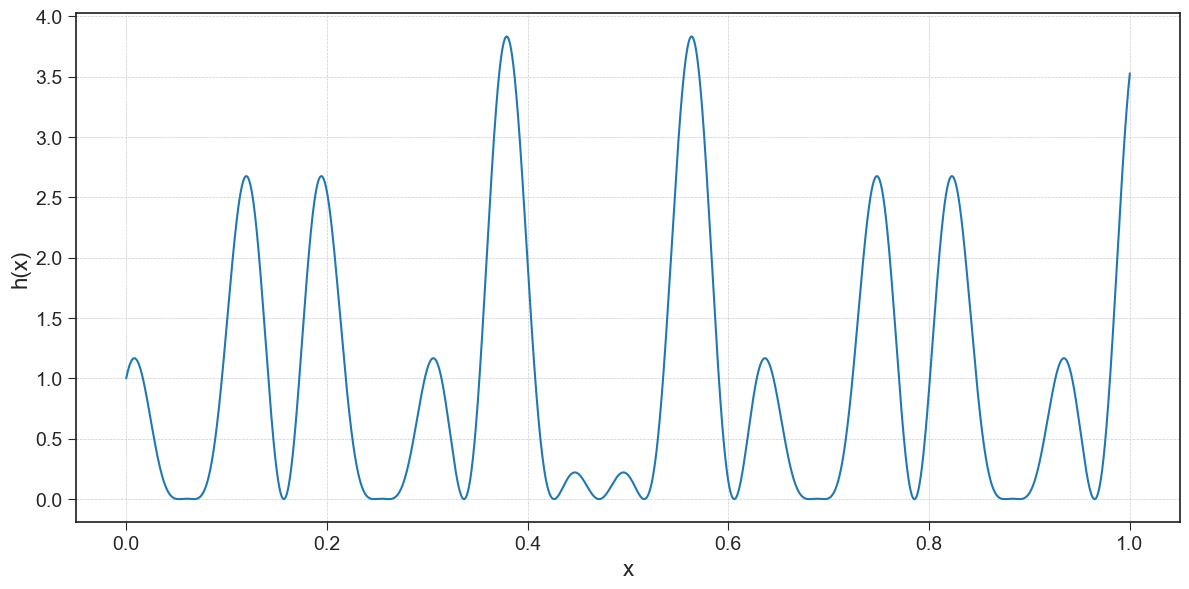

In [226]:
#Define and chart target function
def h_MC(x):
    return (np.cos(50*x) + np.sin(20*x))**2

x = np.linspace(0,1,10000)


plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(x,h_MC(x),color=colors[1] )
plt.xlabel('x', fontsize=16)
plt.ylabel('f(x)', fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [833]:
def MCI(h, f_samples, n):
    """Perform Monte Carlo Integration (MCI) to estimate the expectation of h(x) under f(x) using n samples drawn from f(X).

    Args:
        h (callable): The function h(x) whose expectation you want to estimate.
        f_samples (np.ndarray): n samples drawn from the target distribution f(x).
        n (int): Number of samples.
        
    Returns:
        mu (float): The estimate of the expectation of h(x) under the target distribution f(x).
        std_error (float): The standard error of the estimated expectation.
    """
    
    values = h(f_samples)
    mu = np.sum(values)/n
    var = np.sum((values - mu)**2)
    std_error = np.sqrt(var) / n
        
    return mu, std_error

In [828]:
n_MCI = 10000
n_values_MCI = np.arange(1, n_MCI)
estimates_MCI = []
upper_bounds_MCI = []
lower_bounds_MCI = []
for k in n_values_MCI:
    f_MC = stats.uniform(0,1).rvs(k)
    mu_MCI, error_MCI = MCI(h_MC,f_MC, k)
        
    CI = 2*error_MCI
    upper_MCI = mu_MCI + CI
    lower_MCI = mu_MCI - CI
    
    estimates_MCI.append(mu_MCI)
    upper_bounds_MCI.append(upper_MCI)
    lower_bounds_MCI.append(lower_MCI)

Result of integration: 0.9652009360501453
Estimated error: 1.8542214725442152e-10
Average of MC approximations: 0.9652457008030475


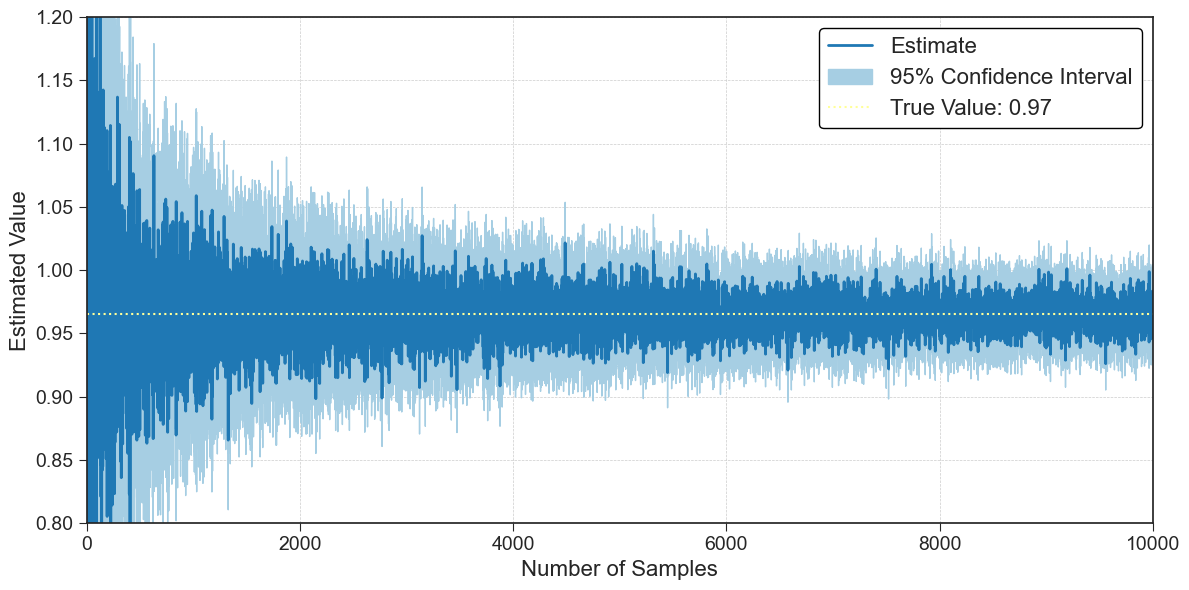

In [829]:
#Calculate exact result and compare with MC approximation
result_MCI, error_MCI2= quad(h_MC, 0, 1)

print("Result of integration:", result_MCI)
print("Estimated error:", error_MCI2)
print("Average of MC approximations:",np.mean(estimates_MCI))


# Plot the results
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(n_values_MCI, estimates_MCI, linewidth=2, color=colors[1], label='Estimate',)
plt.fill_between(n_values_MCI, lower_bounds_MCI, upper_bounds_MCI, color=colors[0], label='95% Confidence Interval')
plt.axhline(y=result_MCI, color=colors[10],linewidth=1.5, linestyle=':', label=f'True Value: {result_MCI:.2f}')


plt.xlabel('Number of Samples', fontsize=16)
plt.ylabel('Estimated Value', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.xlim(0,n_MCI)
plt.ylim(0.8,1.2)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

## Importance Sampling

In this case, let us assume are trying to estimate 
$$
\mathbb{E}_f[h(x)] = \int_0^{10} e^{-2 |x-5|} dx = 10 \int_0^{10} \frac{1}{10} e^{-2 |x-5|} dx
$$
where we can conveniently define
* $h(x)= e^{-2 |x-5|}$,
* $f(x) = \frac{1}{10}$, $x \sim U(0,10)$

We can try to approximate this integral using basic Monte Carlo Integration, however, we can also rely on Importance Sampling and choose our importance function $g(x)$ as  
$$
g(X) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}(x-5)^2}, 
$$
to get a better approximation of the result.

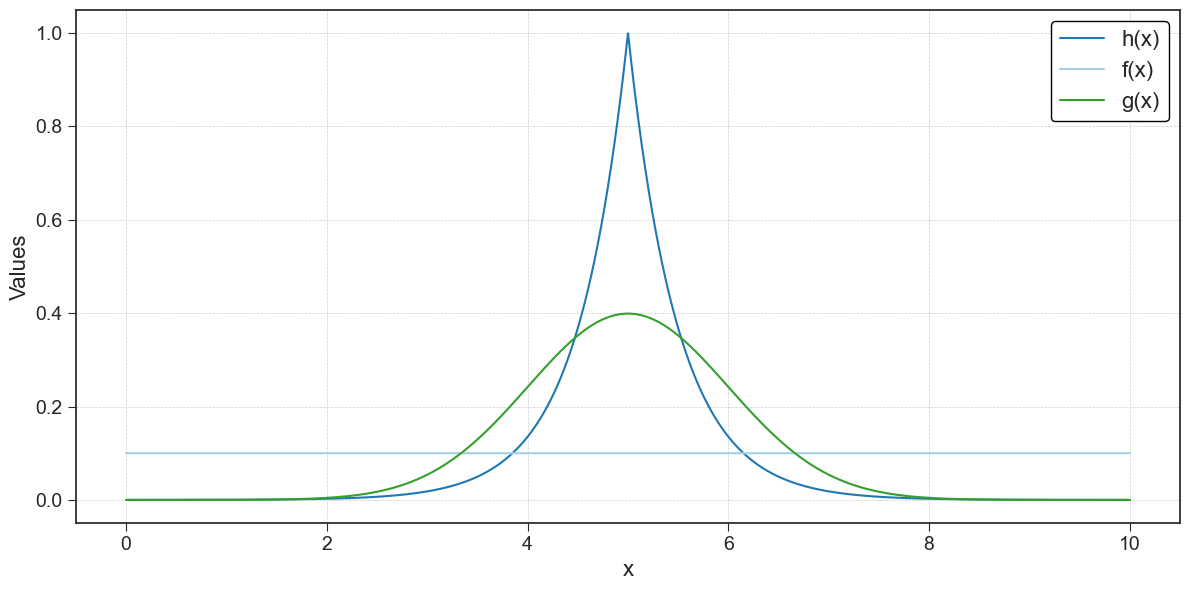

In [816]:
#Define the functions
def h_IS(x):
    return 10*np.exp(-2*np.abs(x-5))
def f_IS(x):
    return stats.uniform.pdf(x,loc=0,scale=10)
def g_IS(x):
    return stats.norm.pdf(x, loc=5, scale =1)

#Plot the functions
x = np.linspace(0,10,10000)

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(x,np.exp(-2*np.abs(x-5)),color=colors[1], label = 'h(x)')
plt.plot(x,f_IS(x), color=colors[0], label = 'f(x)')
plt.plot(x,g_IS(x), color=colors[3], label='g(x)')

plt.xlabel('x', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.xlim(-0.5,10.5)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [836]:
def IS(h,f,g, g_samples, n):
    """Perform Importance Sampling to estimate the expectation of h(x) under the target distribution f(x) using n samples drawn from g(x).

    Args:
        h (callable): The function h(x) whose expectation you want to estimate.
        f (callable): The target distribution f(x) (possibly unnormalized) used to compute the importance weights.
        g (callable): The proposal distribution g(x), from which samples are drawn.
        g_samples (np.ndarray): n samples drawn from the proposal distribution g(x).
        n (int): Number of samples.

    Returns:
        mu (float): The estimate of the expectation of h(x) under the target distribution f(x).
        std_error (float): The standard error of the estimated expectation.
    """
    
    weights = f(g_samples) / g(g_samples)
    values = weights * h(g_samples)    
    
    mu = np.sum(values)/n
    var = np.sum((values - mu)**2)
    std_error = np.sqrt(var)/n
    
    return mu, std_error

In [837]:
n_IS = 1000
n_values_IS = np.arange(1, n_IS)

estimates_MC = []
upper_bounds_MC = []
lower_bounds_MC = []
estimates_IS = []
upper_bounds_IS = []
lower_bounds_IS = []

for k in n_values_IS:
    #Calculate MC approximation
    f_IS_Samples = stats.uniform(0,10).rvs(k)
    mu_MC, error_MC = MCI(h_IS,f_IS_Samples,k)

    CI_MC = 2*error_MC
    upper_MC = mu_MC + CI_MC
    lower_MC = mu_MC - CI_MC
    
    estimates_MC.append(mu_MC)
    upper_bounds_MC.append(upper_MC)
    lower_bounds_MC.append(lower_MC)
    
    #Calculate IS approximation
    g_IS_samples = stats.norm(5,1).rvs(k)
    mu_IS, error_IS = IS(h_IS,f_IS,g_IS,g_IS_samples,k)
    
    CI_IS = 2*error_IS
    upper_IS = mu_IS + CI_IS
    lower_IS = mu_IS - CI_IS
    
    estimates_IS.append(mu_IS)
    upper_bounds_IS.append(upper_IS)
    lower_bounds_IS.append(lower_IS)
    

Result of integration: 0.999954600070238
Estimated error: 2.8421709430404007e-13
Average of MCI approximations: 0.9961455018972304
Average of IS approximations: 0.9979345347826305


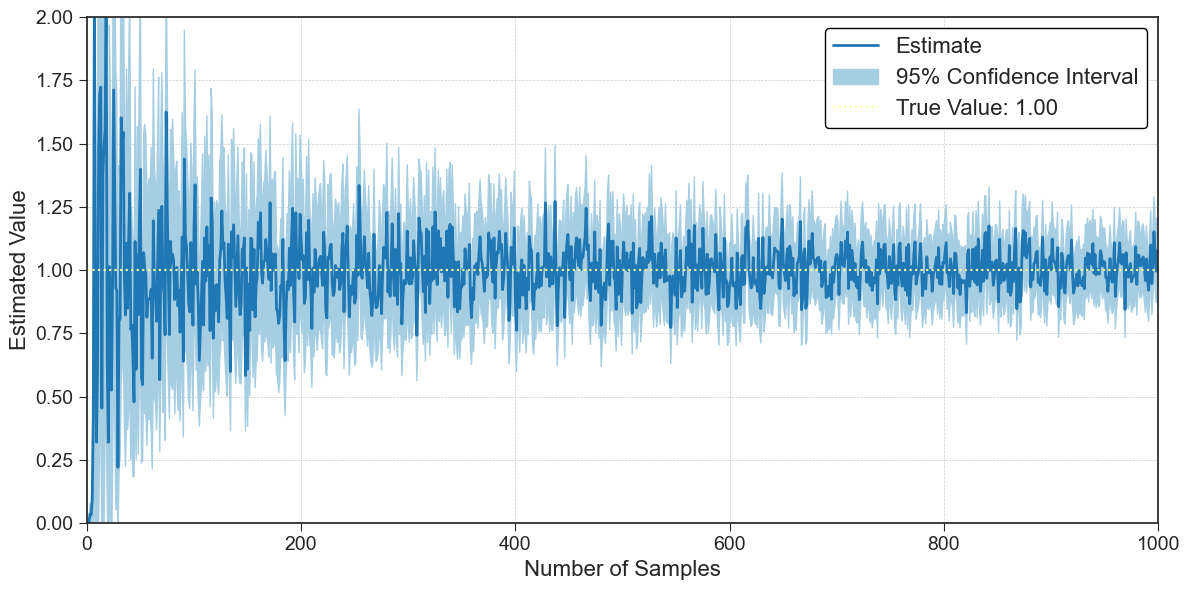

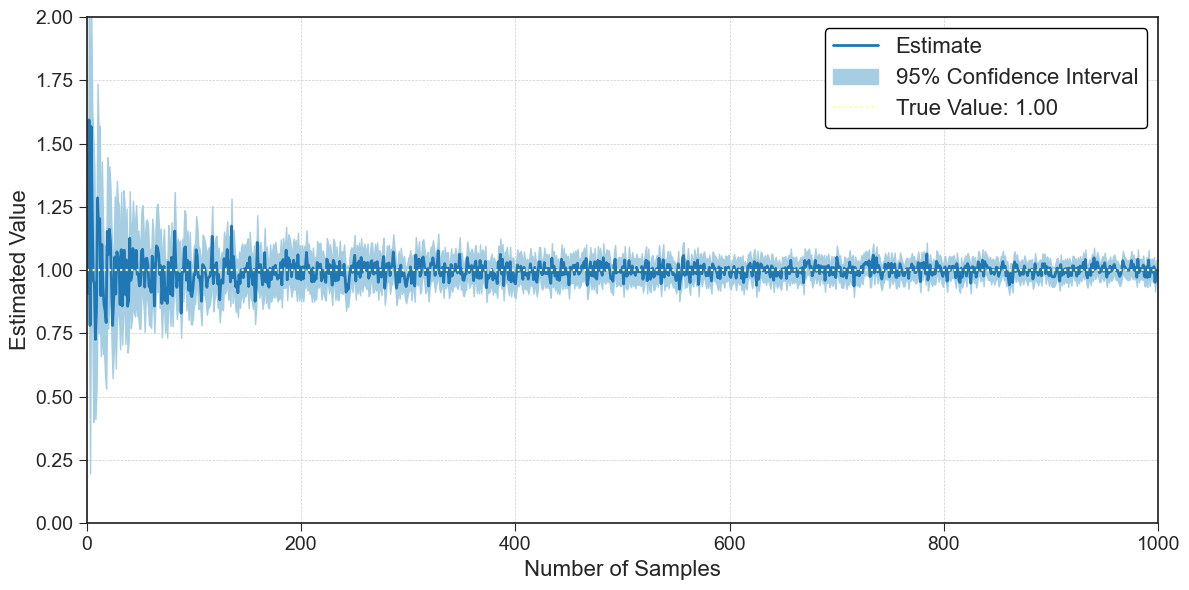

In [838]:
#Calculate exact result and compare with our MC approximation
result_IS, error_IS2 = quad(h_IS, 0, 10)

print("Result of integration:", result_IS/10)
print("Estimated error:", error_IS2)
print("Average of MCI approximations:",np.mean(estimates_MC))
print("Average of IS approximations:",np.mean(estimates_IS))


# Plot MCI results
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(n_values_IS, estimates_MC, linewidth=2, color=colors[1], label='Estimate')
plt.fill_between(n_values_IS, lower_bounds_MC, upper_bounds_MC, color=colors[0], alpha=1, label='95% Confidence Interval')
plt.axhline(y=result_IS/10, color=colors[10], linewidth=1.5, linestyle=':', label=f'True Value: {result_IS/10:.2f}')

plt.xlabel('Number of Samples', fontsize=16)
plt.ylabel('Estimated Value', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.xlim(0,n_IS)
plt.ylim(0,2)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()


# Plot IS results
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(n_values_IS, estimates_IS, linewidth=2, color=colors[1], label='Estimate')
plt.fill_between(n_values_IS, lower_bounds_IS, upper_bounds_IS, color=colors[0], label='95% Confidence Interval')
plt.axhline(y=result_IS/10, color=colors[10], linewidth=1.5, linestyle=':', label=f'True Value: {result_IS/10:.2f}')

plt.xlabel('Number of Samples', fontsize=16)
plt.ylabel('Estimated Value', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.xlim(0,n_IS)
plt.ylim(0,2)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

## Self Normalized Importance Sampling

Lets assume we are trying to estimate the integral of 
$$
\mathbb{E}_f[h(x)] = \int_0^\infty \frac{1}{Z} x^3 e^{-3x} dx, \quad x\geq 0,
$$
where we define $h(x) = x$ and $f(x) = \frac{1}{Z} x^2 e^{-3x}$ is a $\Gamma(3,3)$ distribution with normalization constant $Z = 2/27$ which we will asume to have forgotten.

Our goal is to use the SNIS algorithm to estimate the value of this integral together with the value of $Z$ using the truncated normal $g(X) \sim N_{[0,\infty]}(1,1)$ as our importance sampling distribution. 

Since $Z = \int_0^\infty x^2 e^{-3x} dx$ if we define $f_0(x)= x^2 e^{-3x}$ we know that we can aproximate it using
\begin{align*}
Z &= \int_0^\infty f_0(x) dx = \int_0^\infty \frac{f_0(x)}{g(x)}g(x) dx = \int_0^\infty w(x)g(x)dx \approx \frac{1}{n} \sum_{i=1}^n w(x_i)
\end{align*}

Therefore
\begin{align*}
\int_0^\infty \frac{h(x)f_0(x)}{Z} dx &= \int_0^\infty \frac{h(x)f_0(x)g(x)/g(x)}{\int_0^\infty f_0(x)g(x)/g(x)dx}  dx = \int_0^\infty \frac{w(x)h(x)g(x)dx}{\int_0^\infty w(x)g(x)dx} \\
& \approx \sum_{i=1}^n \frac{w(x_i)h(x_i)}{\sum_{i=1}^n w(x_i)} = \sum_{i=1}^n \bar{w}(x_i)h(x_i)
\end{align*}

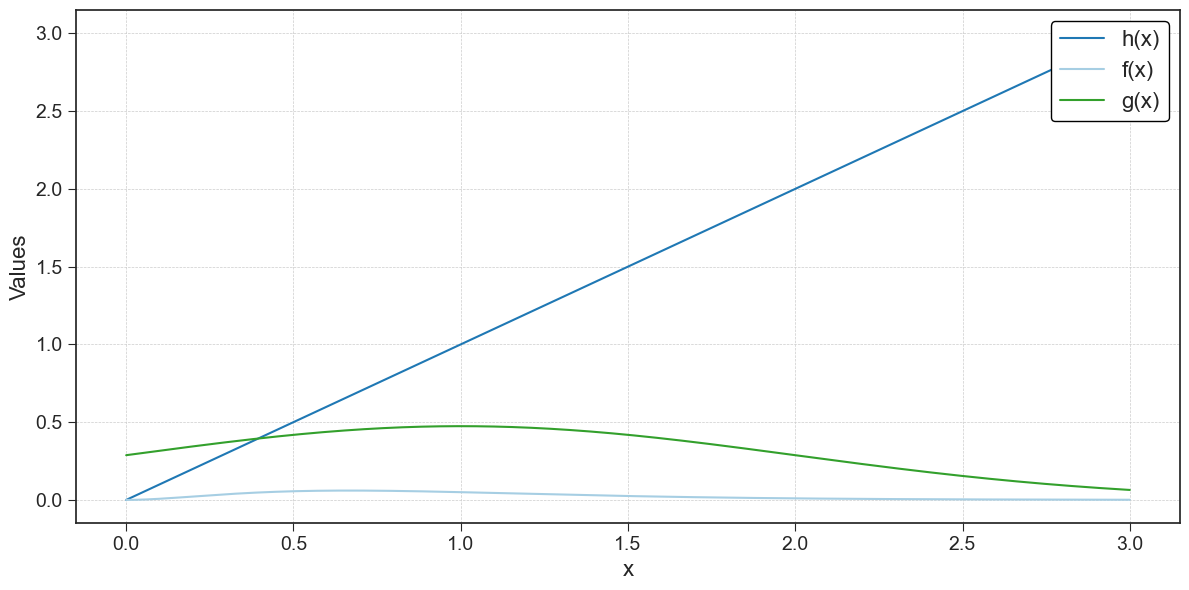

In [830]:
#Define the functions
def h_SNIS(x):
    return x #np.ones_like(x)

def f_SNIS(x):
    return x**2 * np.exp(-3*x)

def g_SNIS(x):
    return stats.truncnorm(a=-1, b=np.inf, loc=1, scale=1).pdf(x)


#Plot the functions
x = np.linspace(0,3,1000)

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(x,h_SNIS(x), color=colors[1], label = 'h(x)')
plt.plot(x,f_SNIS(x), color=colors[0], label = 'f(x)')
plt.plot(x,g_SNIS(x), color=colors[3], label='g(x)')

plt.xlabel('x', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [834]:
def SNIS(h,f,g, g_samples, n):
    """Perform Self-Normalized Importance Sampling (SNIS) to estimate the expectation of h(x)f(x) using n samples drawn from g(X).

    Args:
        h (callable): The function h(x) whose expectation you want to estimate (e.g., h(x) = x^2).
        f (callable): The target distribution f(x) (possibly unnormalized) used to compute the importance weights.
        g (callable): The proposal distribution g(x), from which samples are drawn.
        g_samples (np.ndarray): n samples drawn from the proposal distribution g(x).
        n (int): Number of samples.

    Returns:
        mu (float): The estimate of the expectation of h(x) under the target distribution f(x).
        std_error (float): The standard error of the estimated expectation.
        ESS (float): The effective sample size, indicating the quality of the sample set.
        Z (float): The estimate of the normalization constant for f(x).
        Z_error (float): The standard error of the estimate for the normalization constant Z.
    """
    
    weights = f(g_samples) / g(g_samples)
    w_sum = weights.sum()
    normalized_w = weights / w_sum
    
    Z = w_sum/n
    Z_var = np.sum((weights-Z)**2)
    Z_error = np.sqrt(Z_var)/n
    
    h_values = h(g_samples)
    values = normalized_w * h_values  
    mu = np.sum(values)
    
    var = np.sum(normalized_w**2*(h_values - mu)**2)
    std_error = np.sqrt(var)
    
    ESS = 1 / (normalized_w**2).sum()
    
    
    return mu, std_error, ESS, Z, Z_error

In [809]:
n_SNIS = 1000
n_values_SNIS = np.arange(1, n_SNIS)

estimates_SNIS = []
upper_bounds_SNIS = []
lower_bounds_SNIS = []
ESS_SNIS = []

Z_SNIS = []
Z_upper_bounds_SNIS = []
Z_lower_bounds_SNIS = []

for k in n_values_SNIS:
    samples = stats.truncnorm(a=-1, b=np.inf, loc=1, scale=1).rvs(k)
    mu, error, ESS, Z, Z_error = SNIS(h_SNIS,f_SNIS,g_SNIS, samples, k)
    
    CI = 2 * error
    upper_SNIS = mu + CI
    lower_SNIS = mu - CI
    
    estimates_SNIS.append(mu)
    upper_bounds_SNIS.append(lower_SNIS)
    lower_bounds_SNIS.append(upper_SNIS)
    ESS_SNIS.append(ESS)
    
    Z_CI = 2 * Z_error
    Z_upper_SNIS = Z + Z_CI
    Z_lower_SNIS = Z - Z_CI
    
    Z_SNIS.append(Z)
    Z_upper_bounds_SNIS.append(Z_upper_SNIS)
    Z_lower_bounds_SNIS.append(Z_lower_SNIS)

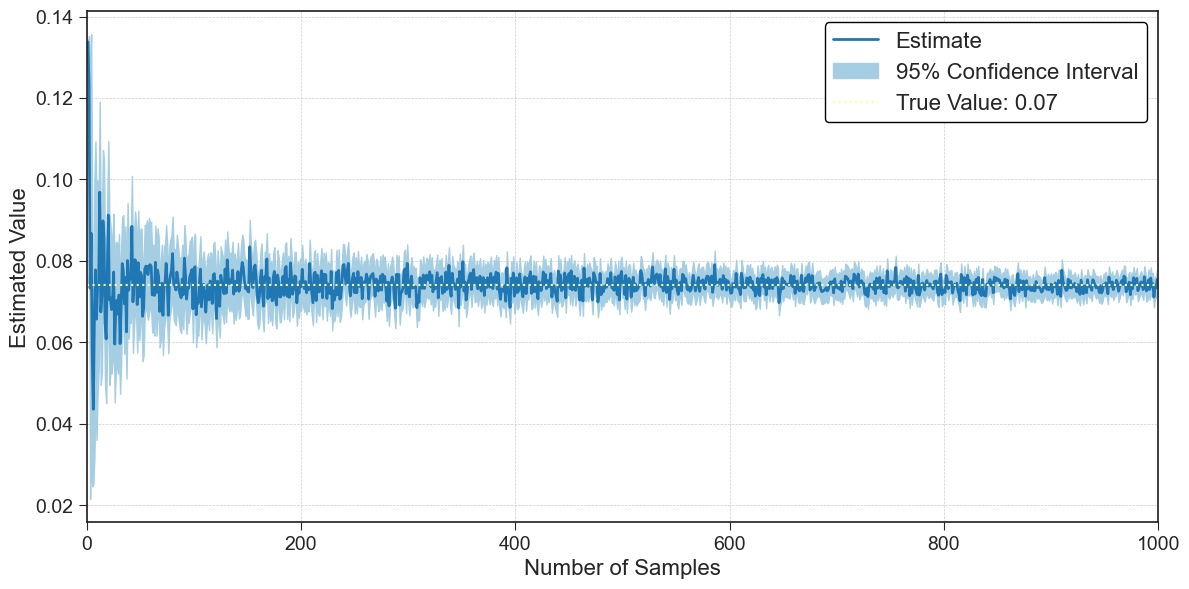

In [810]:
# Plot SNIS results
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(n_values_SNIS, Z_SNIS,  linewidth=2, color=colors[1], label='Estimate')
plt.fill_between(n_values_SNIS, Z_lower_bounds_SNIS, Z_upper_bounds_SNIS, color=colors[0], label='95% Confidence Interval')
plt.axhline(y=2/27, color=colors[10], linewidth=1.5, linestyle=':', label=f'True Value: {2/27:.2f}')

plt.xlabel('Number of Samples', fontsize=16)
plt.ylabel('Estimated Value', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.xlim(0,n_SNIS)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

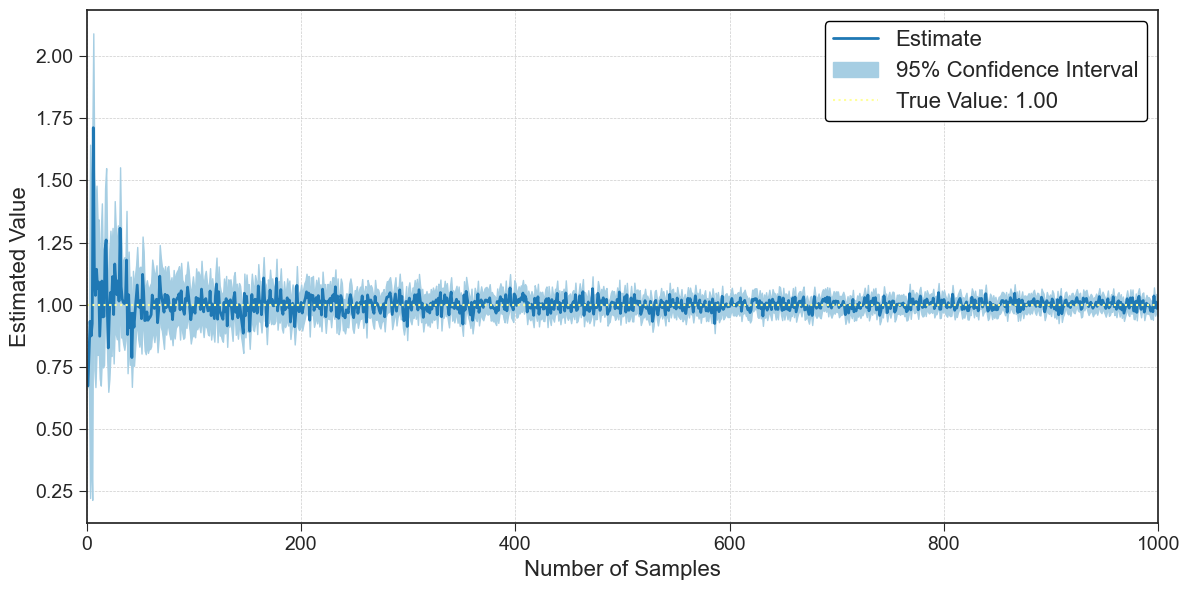

In [811]:
# Plot SNIS results
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(n_values_SNIS, estimates_SNIS,  linewidth=2, color=colors[1], label='Estimate')
plt.fill_between(n_values_SNIS, lower_bounds_SNIS, upper_bounds_SNIS, color=colors[0], label='95% Confidence Interval')
plt.axhline(y=1, color=colors[10], linewidth=1.5, linestyle=':', label=f'True Value: {1:.2f}')

plt.xlabel('Number of Samples', fontsize=16)
plt.ylabel('Estimated Value', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.xlim(0,n_SNIS)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

# Sampling Importance Resampling

Suppose we want to generate a random sample distributed according to 
$$
f(x) = \frac{1}{Z} x^{3/2}e^{-x/2}, \quad x \geq 0
$$
where $f \sim \chi^2(5)$ and we will assume to have forgotten its normalization constant $Z = 6 \sqrt{2 \pi}$.

We can make use of Sampling Importance Resampling to generate a sample approximadetly distributed as $f$ while approximating the real value of $Z$. 

Without a loss in generality let us take $g(X) \sim N_{[0,\infty]}(4,3)$ as our importance distribution.

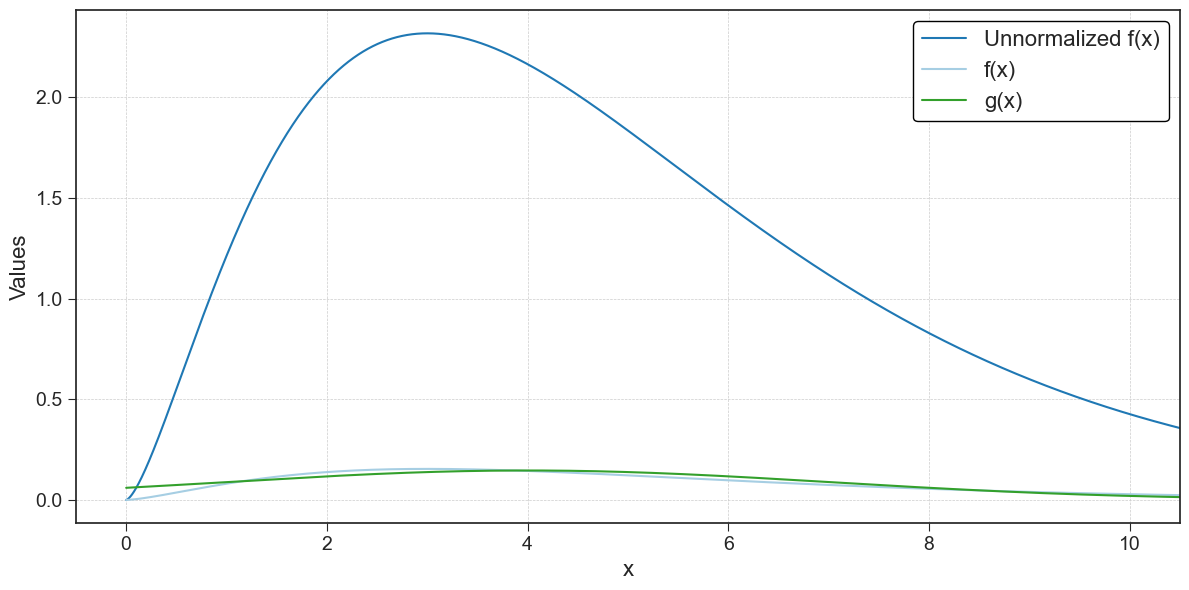

In [909]:
#Defiine the functions:
def f(x):
    return stats.chi2(5).pdf(x)

def g(x):
    return stats.truncnorm(a=-4/3, b=np.inf, loc=4, scale=3).pdf(x)

def f0(x):
    return stats.chi2(5).pdf(x)*6*np.sqrt(2*np.pi)

#Plot the functions
x = np.linspace(0,20,10000)

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(x,f0(x), color=colors[1], label = 'Unnormalized f(x)')
plt.plot(x,f(x), color=colors[0], label = 'f(x)')
plt.plot(x,g(x), color=colors[3], label='g(x)')

plt.xlabel('x', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.xlim(-0.5,10.5)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [882]:
def MC_SIR(f, g, g_samples, n):
    """Use Sampling Importance Resampling (SIR) to estimate the normalization constant Z and resample from the target distribution f(x).

    Args:
        f (callable): The target distribution f(x), possibly unnormalized, used to compute the importance weights.
        g (callable): The proposal distribution g(x) used to compute the importance weights.
        g_samples (np.ndarray): n samples drawn from the proposal distribution g(x).
        n (int): Number of samples.
        
    Returns:
        Z (float): Estimate of the normalization constant for the target distribution f(x).
        Z_std_error (float): Standard error of the normalization constant Z.
        new_samples (np.ndarray): Resampled points from f(x) based on the importance weights.
    """
    
    weights = f(g_samples) / g(g_samples)
    w_sum = weights.sum()
    norm_weights = weights / w_sum
    
    Z = w_sum/n
    Z_var = np.sum((weights - Z)**2)
    Z_error = np.sqrt(Z_var)/n
    
    offsprings = np.random.multinomial(n,norm_weights)
    indices = np.arange(len(norm_weights))  
    new_samples = np.repeat(samples[indices], offsprings) 
            
    return Z, Z_error, new_samples

In [923]:
Z_real = 6*np.sqrt(2*np.pi)

n_SIR = 5000
samples = stats.truncnorm(a=-4/3, b=np.inf, loc=4, scale=3).rvs(n_SIR)

Z_SIR, S_SIR_error, SIR_samples = MC_SIR(f0, g, samples, n_SIR)

print('Real value of Z: {:.2f}'.format(Z_real))
print('Estimated value of Z: {:.2f}'.format(Z_SIR))


Real value of Z: 15.04
Estimated value of Z: 15.01


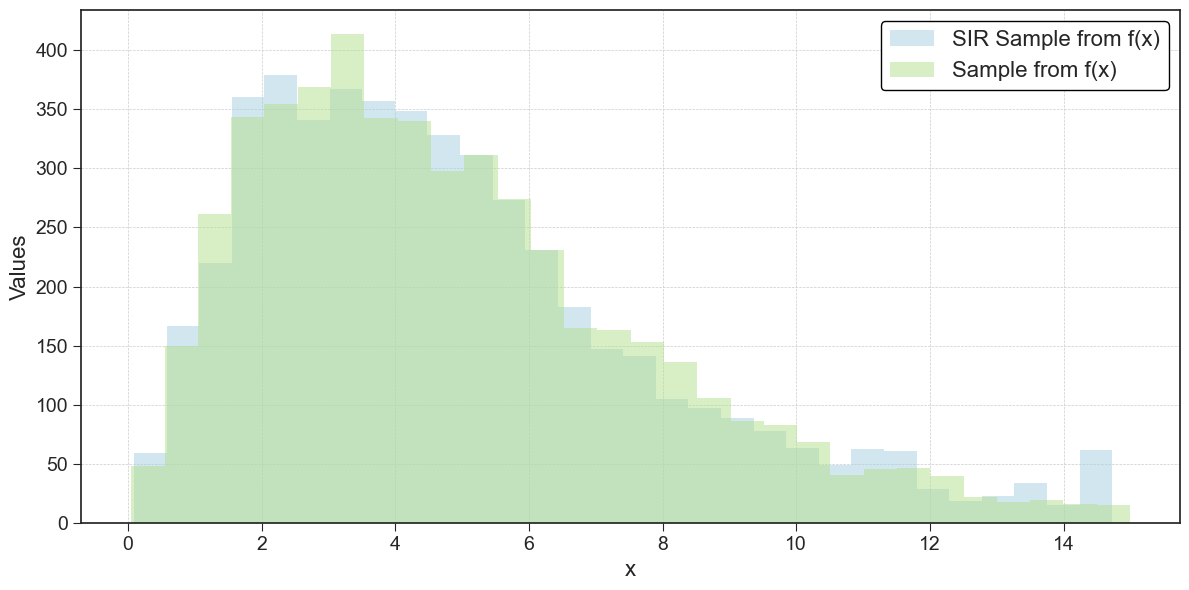

In [950]:
samples_f = stats.chi2(5).rvs(n_SIR)


plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

# plt.hist(samples, bins=30, alpha=0.5, color=colors[0], label='Initial Sample from g(x)')
plt.hist(SIR_samples, bins=30, alpha=0.5, color=colors[0], label='SIR Sample from f(x)')
plt.hist(samples_f[samples_f<15], bins=30, alpha=0.5, color=colors[2], label='Sample from f(x)')

plt.xlabel('x', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()